**Fetal skin**

1. Merge Mac 1 and Mac 2 which then get called --> LYVE1++ Macrophage
2. Microglia --> TREM2+ Macrophage
3. Activated Mac --> Iron recycling Macrophage
4. Mac-mono --> MHCII+ Macrophage
5. Put markers in front of cell type for all other cell types
6. fig1b,c,d merge all macrophages

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln

In [2]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
expr_cmap = sk.expression_colormap()
sk.set_figsize((4, 4))

In [3]:
from time import localtime, strftime


def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

# Find inputs

In [4]:
!tree --prune -P '*.h5ad' .

.
├── cellxgene_h5ad
│   ├── 20220201
│   │   ├── fetal_skin.endothelium.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.erythroid.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.fibroblasts.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.keratinocytes.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.lymphoid_B.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.lymphoid_T_NK.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.mast.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.melanocytes.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.muscle.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.myeloid.cellxgene.20220201.h5ad
│   │   ├── fetal_skin.neuronal.cellxgene.20220201.h5ad
│   │   └── fetal_skin.stroma.cellxgene.20220201.h5ad
│   ├── 20220202
│   │   ├── fetal_skin.endothelium.cellxgene.20220202.h5ad
│   │   ├── fetal_skin.erythroid.cellxgene.20220202.h5ad
│   │   ├── fetal_skin.fibroblasts.cellxgene.20220202.h5ad
│   │   ├── fetal_skin.keratinocytes.cellxgene.20220202.h5ad
│   │   ├── fetal_skin.l

# Update overall object

In [4]:
fsk_all_ad = sc.read("fetal_skin.norm.maternal_removed.20220201.h5ad")

In [5]:
fsk_all_ad.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201'],
      dtype='object')

In [6]:
fsk_all_ad.obs.joint_annotation_20220201b.cat.categories

Index(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal',
       'Basal POSTN+', 'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'Companion layer', 'Cuticle/cortex',
       'DC1', 'DC2', 'Dermal condensate', 'Dermal papillia', 'Early LE',
       'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'Early fibroblast FRZB+',
       'Early fibroblast HOXC5+', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast PEAR1+', 'Fibroblast WNT2+', 'HSC',
       'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal',
       'Inflammatory DC', 'Innate T type1', 'Innate T type3',
       'Inner root sheath', 'LC', 'LE', 'LTi', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'Mac-mono', 'Macrophage',
       'Mast cell (earliest)', 'Mast cell (medium)', 'Mast cell (most mature)',
       'Matrix/placode', 'Megakaryo

In [7]:
fsk_all_ad.obs[
    "joint_annotation_20220202"
] = fsk_all_ad.obs.joint_annotation_20220201b.cat.rename_categories(
    {
        "Basal POSTN+": "POSTN+ basal",
        "Macrophage": "LYVE1++ macrophage",
        "Early fibroblast FRZB+": "FRZB+ early fibroblast",
        "Early fibroblast HOXC5+": "HOXC5+ early fibroblast",
        "Fibroblast WNT2+": "WNT2+ fibroblast",
        "Fibroblast PEAR1+": "PEAR1+ fibroblast",
        "Mac-mono": "MHCII+ macrophage",
        "Microglia": "TREM2+ macrophage",
        "Mural cell LMCD1+": "LMCD1+ mural cell",
        "Mural cell PLN+": "PLN+ mural cell",
        "Activated mac": "Iron-recycling macrophage",
        "Schwann cellls PID1+": "PID1+ schwann cellls",
    }
)

In [8]:
fsk_all_ad.obs.joint_annotation_20220202.cat.categories

Index(['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', 'B cell',
       'Basal', 'POSTN+ basal', 'CD4 T cell', 'CD8 T cell',
       'Capillary (venular tip)', 'Capillary/postcapillary venule',
       'Companion layer', 'Cuticle/cortex', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early LE', 'Early endothelial cell',
       'Early erythroid', 'Early erythroid (embryonic)',
       'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'PEAR1+ fibroblast', 'WNT2+ fibroblast', 'HSC',
       'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal',
       'Inflammatory DC', 'Innate T type1', 'Innate T type3',
       'Inner root sheath', 'LC', 'LE', 'LTi', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'MHCII+ macrophage',
       'LYVE1++ macrophage', 'Mast cell (earliest)', 'Mast cell (medium)',
       'Mast cell (most mature)',

In [9]:
fsk_all_ad.obs.independent_annotation_refined_20220201b.cat.categories

Index(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal KC',
       'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early KC (stem cell)', 'Early LE',
       'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'Early fibroblast FRZB+',
       'Early fibroblast HOXC5+', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast PEAR1+', 'Fibroblast WNT2+', 'HSC',
       'Hair follicle', 'ILC2', 'ILC3', 'Inflammatory DC', 'Innate T type1',
       'Innate T type3', 'LC', 'LE', 'LTi cell', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'Mac-mono', 'Macrophage',
       'Mast cell (earliest)', 'Mast cell (medium)', 'Mast cell (most mature)',
       'Megakaryocyte', 'Melanoblast', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte (activated/di

In [10]:
fsk_all_ad.obs[
    "independent_annotation_refined_20220202"
] = fsk_all_ad.obs.independent_annotation_refined_20220201b.cat.rename_categories(
    {
        "Basal POSTN+": "POSTN+ basal",
        "Macrophage": "LYVE1++ macrophage",
        "Early fibroblast FRZB+": "FRZB+ early fibroblast",
        "Early fibroblast HOXC5+": "HOXC5+ early fibroblast",
        "Fibroblast WNT2+": "WNT2+ fibroblast",
        "Fibroblast PEAR1+": "PEAR1+ fibroblast",
        "Mac-mono": "MHCII+ macrophage",
        "Microglia": "TREM2+ macrophage",
        "Mural cell LMCD1+": "LMCD1+ mural cell",
        "Mural cell PLN+": "PLN+ mural cell",
        "Activated mac": "Iron-recycling macrophage",
        "Schwann cellls PID1+": "PID1+ schwann cellls",
    }
)

In [11]:
fsk_all_ad.obs.independent_annotation_refined_20220202.cat.categories

Index(['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', 'B cell',
       'Basal KC', 'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early KC (stem cell)', 'Early LE',
       'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'FRZB+ early fibroblast',
       'HOXC5+ early fibroblast', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'PEAR1+ fibroblast', 'WNT2+ fibroblast', 'HSC',
       'Hair follicle', 'ILC2', 'ILC3', 'Inflammatory DC', 'Innate T type1',
       'Innate T type3', 'LC', 'LE', 'LTi cell', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'MHCII+ macrophage',
       'LYVE1++ macrophage', 'Mast cell (earliest)', 'Mast cell (medium)',
       'Mast cell (most mature)', 'Megakaryocyte', 'Melanoblast', 'Melanocyte',
       'TREM2+ macrophage'

In [12]:
fsk_all_ad.obs.independent_annotation_broad1_20220201.cat.categories

Index(['ASDC', 'Adipocyte', 'B cell', 'Basal KC', 'CD4 T cell', 'CD8 T cell',
       'DC1', 'DC2', 'Early erythroid', 'Erythroid', 'Fibroblast FRZB+',
       'Fibroblast HF', 'Fibroblast HOX5+', 'Fibroblast WNT2+',
       'Fibroblast dermal papillia', 'Fibroblast unknown',
       'Granulocyte progenitor', 'HF KC', 'HSC', 'ILC2', 'ILC3',
       'Innate T cell', 'Langerhans cell', 'Lti', 'Lymphatic endothelium',
       'Lymphoid progenitor', 'MEMP', 'Mac-mono', 'Macrophage', 'Mast cell',
       'Megakaryocyte', 'Melanoblast', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte precursor', 'Myofibroblast', 'NK cell', 'Neuronal cells',
       'Neutrophil', 'Mural cell', 'Periderm', 'Schwann cell',
       'Skeletal muscle', 'Suprabasal KC', 'Treg', 'Vascular endothelium',
       'pDC'],
      dtype='object')

In [13]:
fsk_all_ad.obs.independent_annotation_broad4.cat.categories

Index(['Antigen Presenting Cells', 'Endothelium', 'Epithelium', 'Erythroid',
       'Lymphocytes', 'Mesenchymal cells', 'Muscle', 'Neuronal cells',
       'Other blood cells'],
      dtype='object')

In [14]:
fsk_all_ad.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201',
       'joint_annotation_20220202', 'independent_annotation_refined_20220202'],
      dt

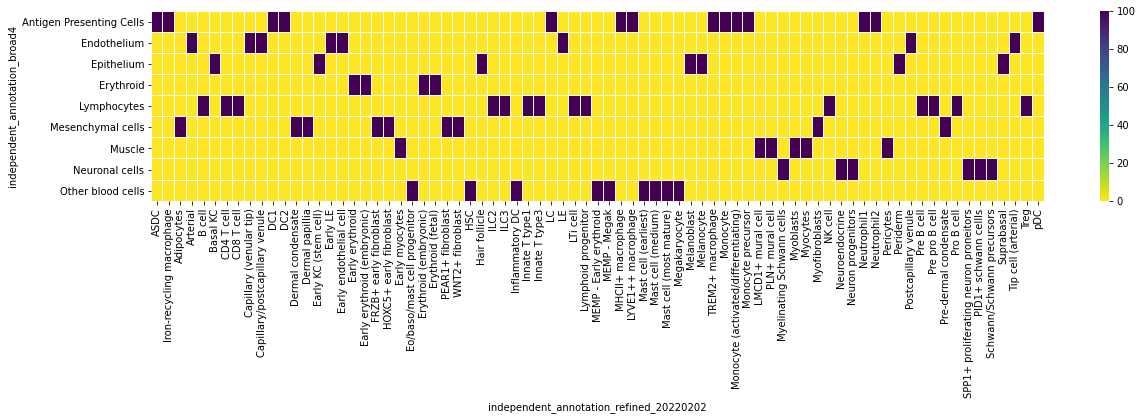

In [15]:
sk.cross_table(
    fsk_all_ad,
    "independent_annotation_broad4",
    "independent_annotation_refined_20220202",
    normalise="xy",
    plot=True,
    figsize=(20, 3.5),
);

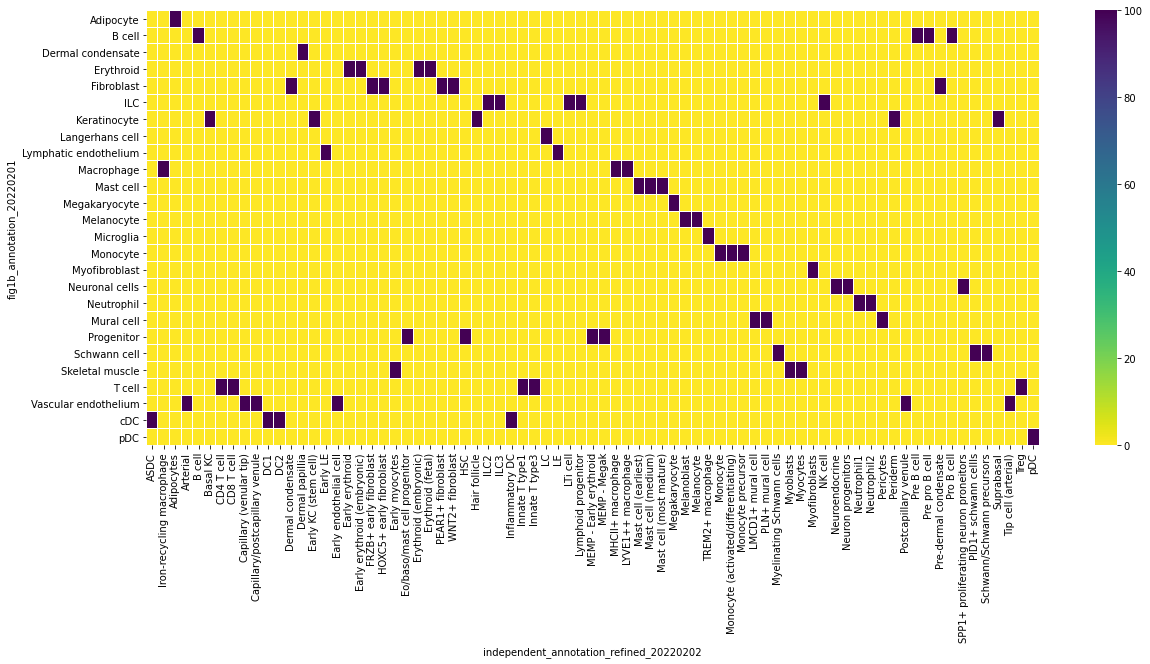

In [16]:
sk.cross_table(
    fsk_all_ad,
    "fig1b_annotation_20220201",
    "independent_annotation_refined_20220202",
    normalise="xy",
    plot=True,
    figsize=(20, 8),
);

In [17]:
fsk_all_ad.obs["fig1b_annotation_20220202"] = sk.regroup(
    fsk_all_ad,
    groupby="fig1b_annotation_20220201",
    regroups={
        "Macrophage": ["Macrophage", "Microglia"],
    },
)

In [18]:
fsk_all_ad.obs.fig1b_annotation_20220202.cat.rename_categories(
    {"Dermal condensate": "Dermal papillia"}, inplace=True
)

In [19]:
fsk_all_ad.obs.fig1b_annotation_20220202.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal papillia', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Monocyte',
       'Mural cell', 'Myofibroblast', 'Neuronal cells', 'Neutrophil',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'T cell',
       'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

save object

In [20]:
fsk_all_ad.write(f"fetal_skin.norm.maternal_removed.20220202.h5ad", compression="lzf")

In [4]:
fsk_all_ad = sc.read("fetal_skin.norm.maternal_removed.20220202.h5ad")

In [5]:
fsk_all_ad.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201',
       'joint_annotation_20220202', 'independent_annotation_refined_20220202',
       'f

In [26]:
fsk_all_ad.obs["sample_name"] = (
    fsk_all_ad.obs["donor"].astype(str)
    + ",pcw"
    + fsk_all_ad.obs["pcw"].astype(str)
    + ","
    + fsk_all_ad.obs["sorting"].astype(str)
)

In [7]:
fsk_all_ad.obs["log1p_n_counts"] = np.log1p(fsk_all_ad.obs.n_counts)
fsk_all_ad.obs["log1p_n_genes"] = np.log1p(fsk_all_ad.obs.n_genes)

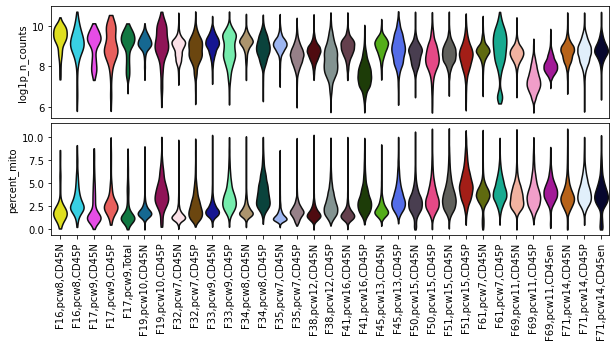

In [38]:
sk._plot.plot_qc_violin(
    fsk_all_ad,
    groupby="sample_name",
    metrics=["log1p_n_counts", "percent_mito"],
    one_per_line=True,
    figsize=(10, 2),
);

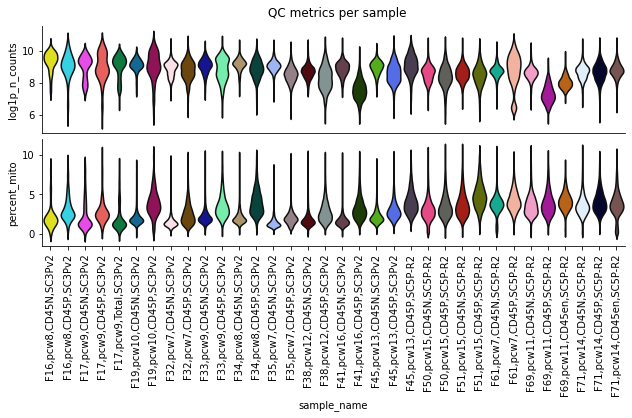

In [325]:
g = sk.plot_qc_violin(
    fsk_all_ad,
    groupby="sample_name",
    metrics=["log1p_n_counts", "percent_mito"],
    one_per_line=True,
    figsize=(10, 2),
    rotation=90,
)
g.fig.suptitle("QC metrics per sample")
g.savefig("../20211022_final_figures/figures/figS1B_a.pdf", bbox_inches="tight")

In [333]:
!rclone copy --drive-shared-with-me ../20211022_final_figures/figures/figS1B_a.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

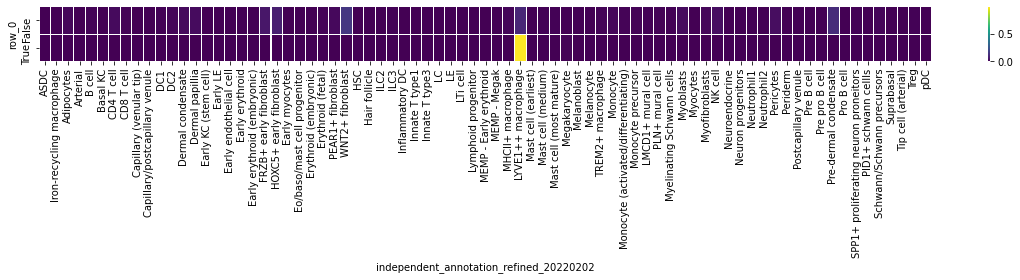

In [ ]:
sk.set_figsize((20, 1))
sn.heatmap(
    pd.crosstab(
        (fsk_all_ad.obs.sanger_id == "FCAImmP7862094") & (fsk_all_ad.obs.n_counts < 1000),
        fsk_all_ad.obs.independent_annotation_refined_20220202,
        normalize="index",
    ),
    cmap="viridis",
    linewidth=0.01,
);

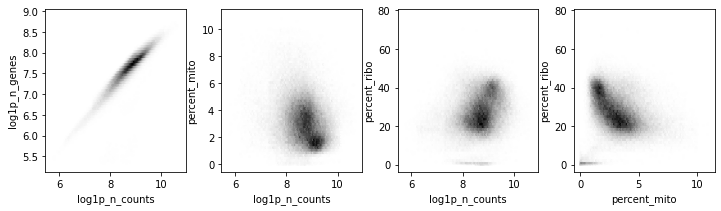

In [304]:
sk._plot.plot_qc_scatter(fsk_all_ad, use_hexbin=True);

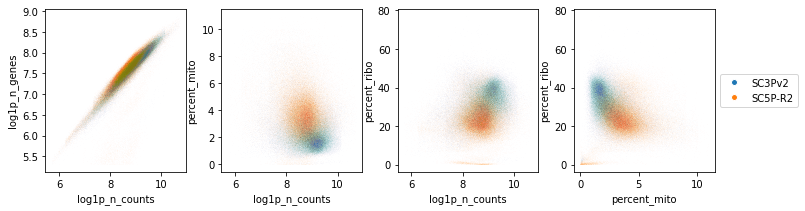

In [341]:
g = sk.plot_qc_scatter(fsk_all_ad, color_by="chemistry", rasterized=True);

In [342]:
g.savefig("../20211022_final_figures/figures/figS1B_c.pdf", bbox_inches="tight")

In [343]:
!rclone copy --drive-shared-with-me ../20211022_final_figures/figures/figS1B_c.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

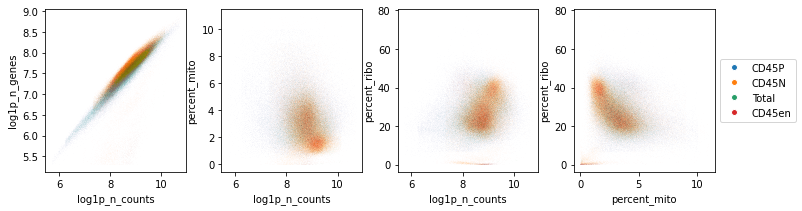

In [296]:
sk._plot.plot_qc_scatter(fsk_all_ad, color_by="sorting");

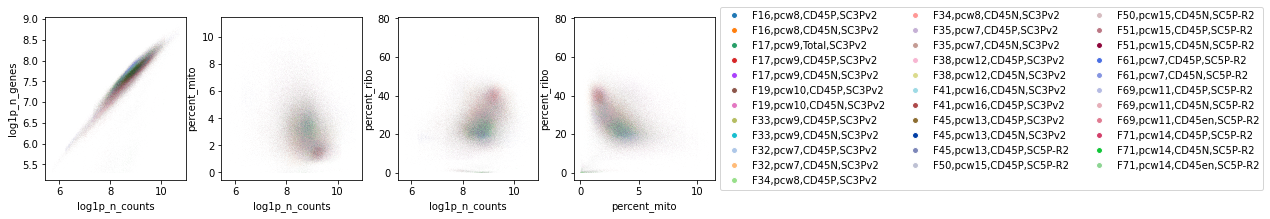

In [330]:
g = sk.plot_qc_scatter(fsk_all_ad, color_by="sample_name")

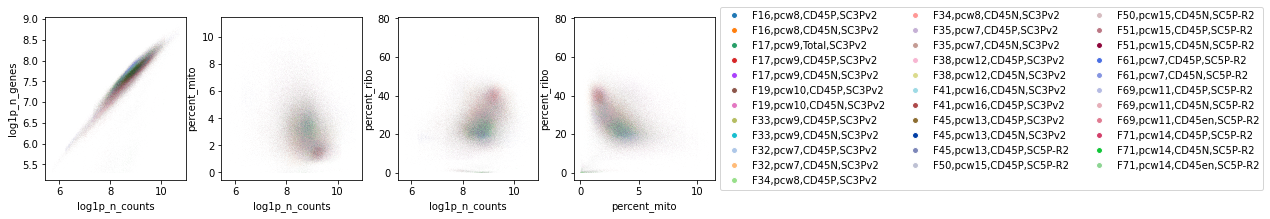

In [337]:
g = sk.plot_qc_scatter(fsk_all_ad, color_by="sample_name", rasterized=True)

In [338]:
g.savefig("../20211022_final_figures/figures/figS1B_b.pdf", bbox_inches="tight")

In [339]:
!rclone copy --drive-shared-with-me ../20211022_final_figures/figures/figS1B_b.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

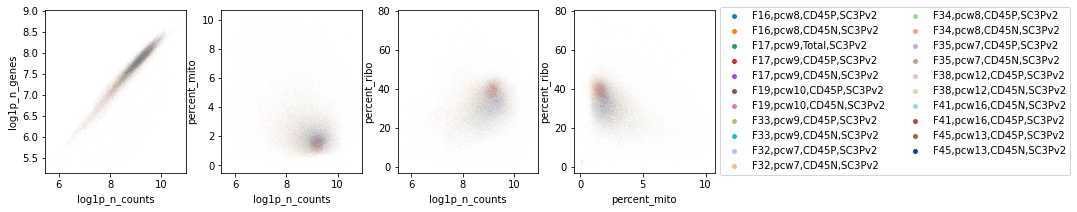

In [298]:
sk._plot.plot_qc_scatter(fsk_all_ad[fsk_all_ad.obs.chemistry == "SC3Pv2"], color_by="sample_name");

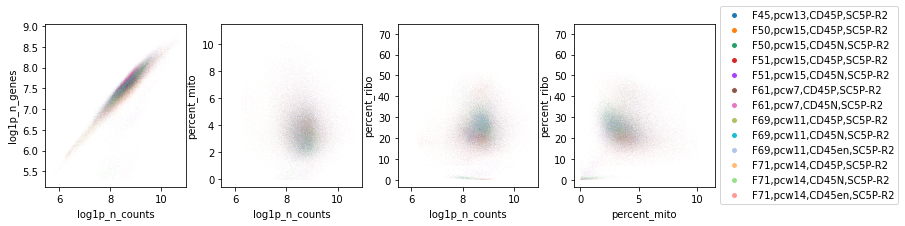

In [299]:
sk._plot.plot_qc_scatter(fsk_all_ad[fsk_all_ad.obs.chemistry == "SC5P-R2"], color_by="sample_name");

In [346]:
fsk_all_ad

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202', 'log1p_n_counts', 'log1p

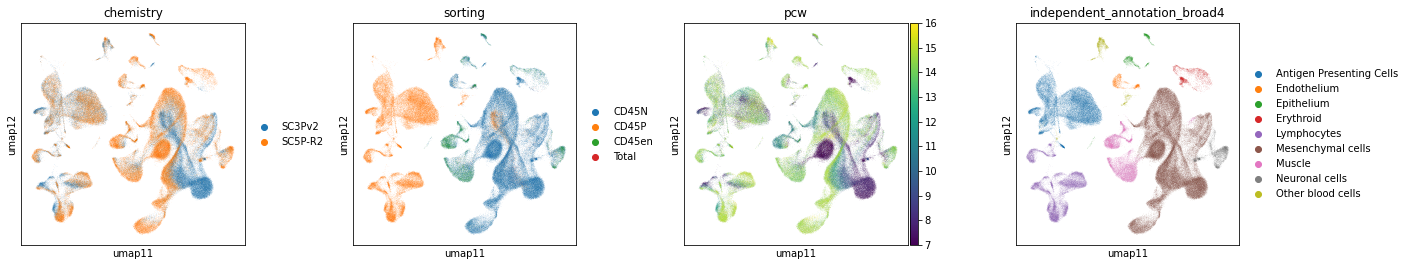

In [361]:
sk.set_figsize((4, 4))
sc.pl.embedding(
    fsk_all_ad,
    basis="umap1",
    color=["chemistry", "sorting", "pcw", "independent_annotation_broad4"],
    size=0.2,
    wspace=0.35,
)

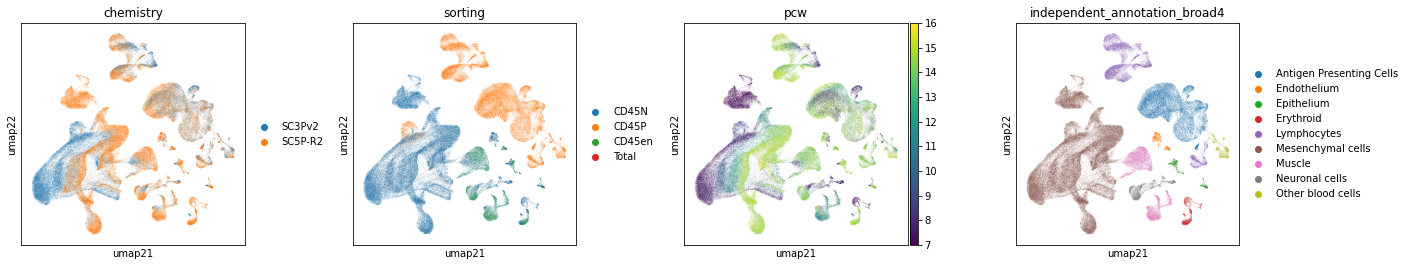

In [365]:
sk.set_figsize((4, 4))
g = sc.pl.embedding(
    fsk_all_ad,
    basis="umap2",
    color=["chemistry", "sorting", "pcw", "independent_annotation_broad4"],
    size=0.2,
    wspace=0.35,
    save="tmp.pdf"
)

In [366]:
!mv figures/umap2tmp.pdf ../20211022_final_figures/figures/figS1B_d.pdf

In [367]:
!rclone copy --drive-shared-with-me ../20211022_final_figures/figures/figS1B_d.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

# Make cellxgene objects per compartment

In [21]:
old_cxg_h5ads = !ls cellxgene_h5ad/20220201

In [22]:
old_cxg_h5ads

['fetal_skin.endothelium.cellxgene.20220201.h5ad',
 'fetal_skin.erythroid.cellxgene.20220201.h5ad',
 'fetal_skin.fibroblasts.cellxgene.20220201.h5ad',
 'fetal_skin.keratinocytes.cellxgene.20220201.h5ad',
 'fetal_skin.lymphoid_B.cellxgene.20220201.h5ad',
 'fetal_skin.lymphoid_T_NK.cellxgene.20220201.h5ad',
 'fetal_skin.mast.cellxgene.20220201.h5ad',
 'fetal_skin.melanocytes.cellxgene.20220201.h5ad',
 'fetal_skin.muscle.cellxgene.20220201.h5ad',
 'fetal_skin.myeloid.cellxgene.20220201.h5ad',
 'fetal_skin.neuronal.cellxgene.20220201.h5ad',
 'fetal_skin.stroma.cellxgene.20220201.h5ad']

In [23]:
for name in pd.Series(old_cxg_h5ads).str.split(".", expand=True)[1].values:
    print(name, end=": ")
    old_h5ad = f"cellxgene_h5ad/20220201/fetal_skin.{name}.cellxgene.20220201.h5ad"
    old_obs = sk.read_h5ad(old_h5ad, component="obs")
    old_obsm = sk.read_h5ad(old_h5ad, component="obsm")
    old_k = old_obs.index.isin(fsk_all_ad.obs_names)
    common_cells = old_obs.index[old_k]
    print(common_cells.size)
    if common_cells.size == 0 or np.any(
        common_cells != fsk_all_ad.obs_names[fsk_all_ad.obs_names.isin(common_cells)]
    ):
        print(f"pass {name}")
        continue
    new_ad = fsk_all_ad[fsk_all_ad.obs_names.isin(common_cells)]
    for obsm_key in old_obsm.keys():
        embed = old_obsm[obsm_key][old_k, :]
        new_ad.obsm[obsm_key] = embed.copy()
    new_ad.write(
        f"cellxgene_h5ad/20220202/fetal_skin.{name}.cellxgene.20220202.h5ad", compression="lzf"
    )
    del new_ad

endothelium: 2173
erythroid: 3468
fibroblasts: 90807
keratinocytes: 1469
lymphoid_B: 3676
lymphoid_T_NK: 17551
mast: 2641
melanocytes: 794
muscle: 15188
myeloid: 35151
neuronal: 5643
stroma: 119610


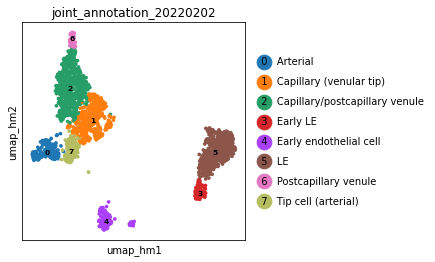

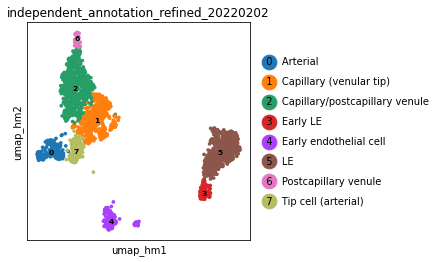

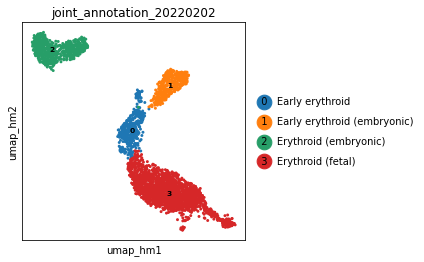

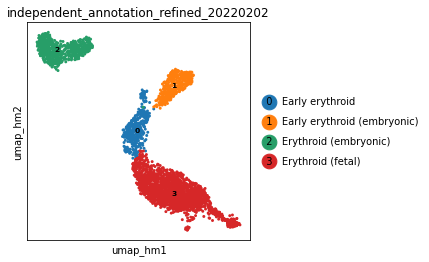

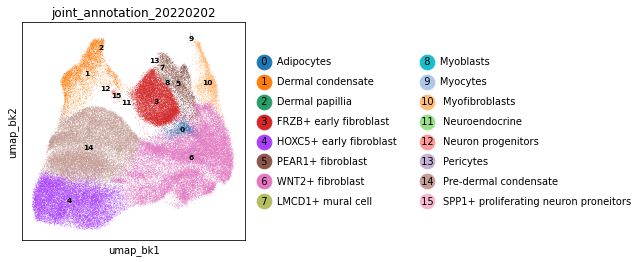

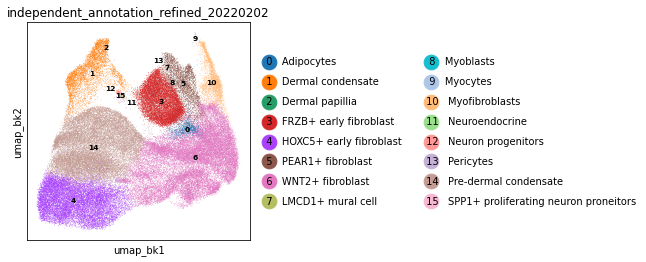

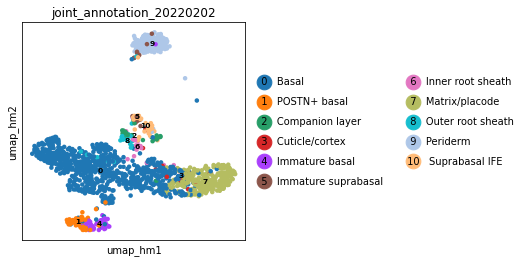

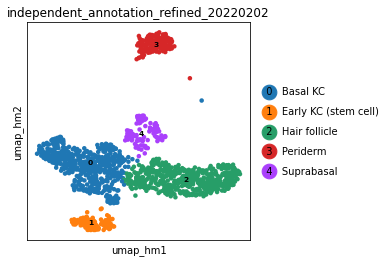

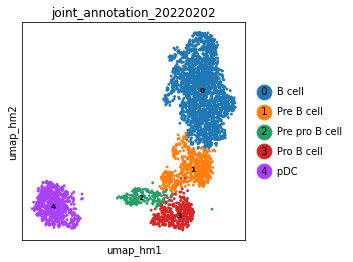

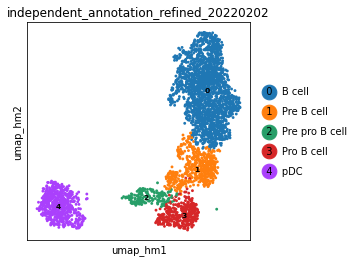

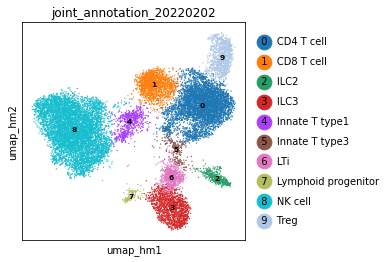

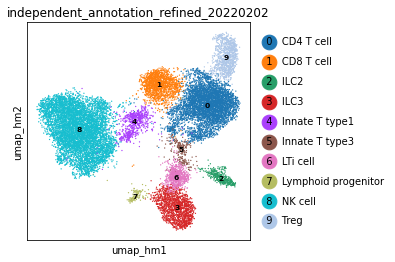

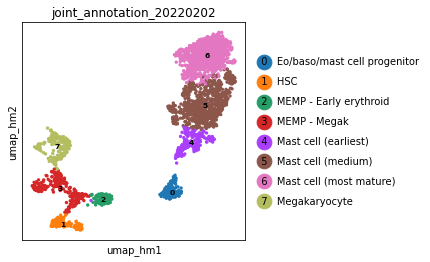

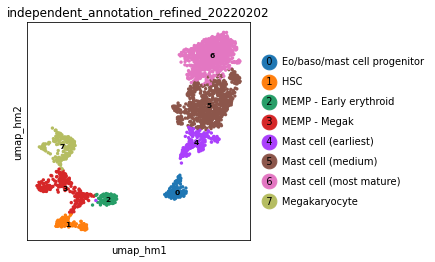

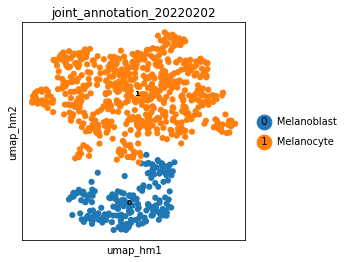

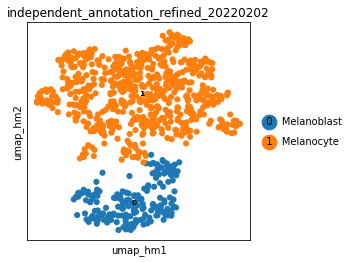

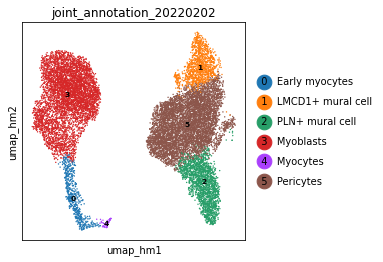

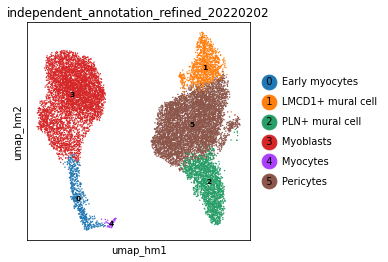

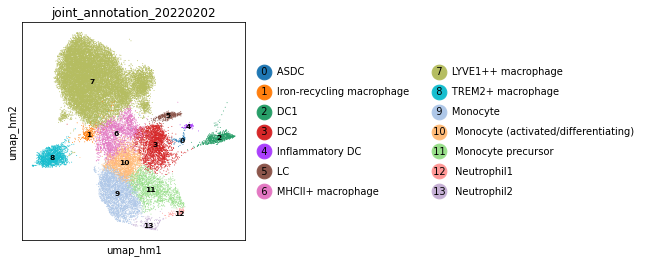

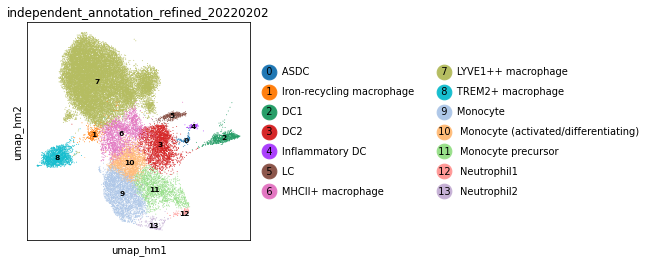

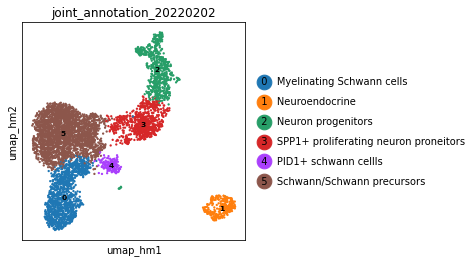

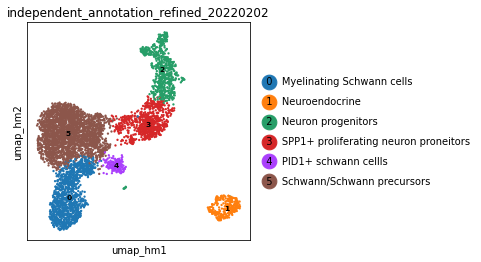

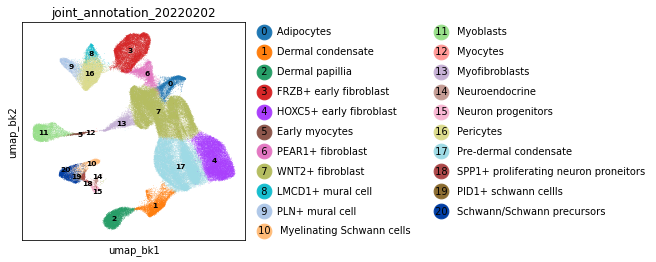

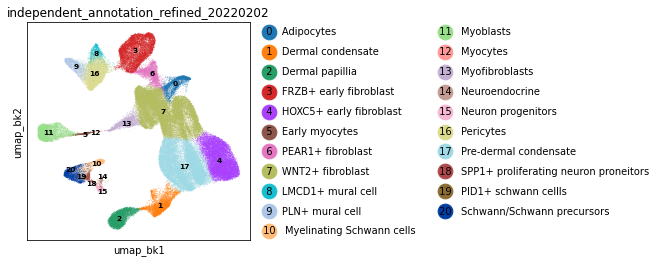

In [26]:
for name in pd.Series(old_cxg_h5ads).str.split(".", expand=True)[1].values:
    new_ad = sc.read(
        f"cellxgene_h5ad/20220202/fetal_skin.{name}.cellxgene.20220202.h5ad", backed="r"
    )
    basis = "umap_bk" if name in ("stroma", "fibroblasts") else "umap_hm"
    sk.plot_embedding(new_ad, basis=basis, groupby="joint_annotation_20220202")
    sk.plot_embedding(new_ad, basis=basis, groupby="independent_annotation_refined_20220202")
    sk.clear_colors(new_ad)
    del new_ad

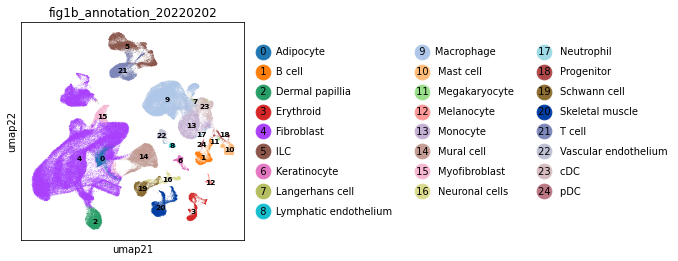

In [25]:
sk.plot_embedding(fsk_all_ad, basis="umap2", groupby="fig1b_annotation_20220202");

# Make a TREM2+ macrophage object

In [4]:
fetal_all_ad = sc.read("fetal_skin.norm.maternal_removed.20220202.h5ad")

In [5]:
(fetal_all_ad.obs.independent_annotation_refined_20220202 == "TREM2+ macrophage").sum()

1617

In [6]:
trem2_ad = fetal_all_ad[
    fetal_all_ad.obs.independent_annotation_refined_20220202 == "TREM2+ macrophage"
].copy()

In [7]:
trem2_ad

AnnData object with n_obs × n_vars = 1617 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mito'

In [21]:
trem2_count_ad = sk.restore_adata(
    trem2_ad,
    restore_type="count",
    use_raw=False,
    obs_cols=[
        "sanger_id",
        "chemistry",
        "donor",
        "gender",
        "pcw",
        "sorting",
        "sample",
        "chemistry_sorting",
        "scrublet_score",
        "cluster_scrublet_score",
        "doublet_pval",
        "bh_doublet_pval",
        "n_counts",
        "n_genes",
        "percent_mito",
        "percent_ribo",
        "percent_hb",
    ],
    var_cols=["gene_ids", "mito", "ribo", "hb", "n_cells", "cc", "n_counts"],
)

In [29]:
trem2_count_ad.write("fetal_skin.TREM2_macrophage.count.h5ad", compression="lzf")

In [33]:
!rclone copy fetal_skin.TREM2_macrophage.count.h5ad google:/projects/fetal_skin/data/h5ad/20220211_TREM2_macrophage/